<h1 style="text-align:center">The Battle of Neighborhoods<h1>

<h2><strong>Introduction</strong></h2>

New York city is the most populous city in the US. With a population of almost 9 Millions over 790 km2. New York city is also the most densely populated major city in the US.
The city and its metropolitan area constitute the premier gateway for legal immigration to the United States.
With all its diverse culture, we have diverse food. There are a lot of restaurants in New York city, and each restaurant belong to a different culture, such as Chinese, Italian, French and more.

<br>

<h2><strong>Data</strong></h2>

in this project, we will use :<br>
 1.Data about Boroughs, Neighborhoods (with latitude and longitude) of New York City<br>
 2.French Restaurants in each beighborhoods<br>
 3.GeoSpace Data

<br>

<h2><strong>Questions</strong></h2>

### 1.What is the best location for French restaurant in NYC ?
### 2.Which Area have potential French restaurant market ? 
### 3.Which all areas lack French restaurants ?
### 4.Which is the best place to stay if you like French Food ? 

<br>

<h2><strong>Let's Start</strong></h2>

###### lets import all the libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [17]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VIHEYLH325KOT3PCWL5GQ0VFLFAENHDLAIKD2SOYAQWYNGHI' # your Foursquare ID
    CLIENT_SECRET = 'Z420FMVCDOI0VOCFUH4BHPNQXGTH2CSZJRRMZ11QXRB51NKH' # your Foursquare Secret
    VERSION = '20200501' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]["groups"][0]["items"]
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [18]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'VIHEYLH325KOT3PCWL5GQ0VFLFAENHDLAIKD2SOYAQWYNGHI' # your Foursquare ID
    CLIENT_SECRET = 'Z420FMVCDOI0VOCFUH4BHPNQXGTH2CSZJRRMZ11QXRB51NKH' # your Foursquare Secret
    VERSION = '20200501' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

###### get the new york city data

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
new_york_data=get_new_york_data()

In [9]:
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [10]:
new_york_data.shape

(306, 4)

### now let's see with bar plot different neigborhoods in New York City

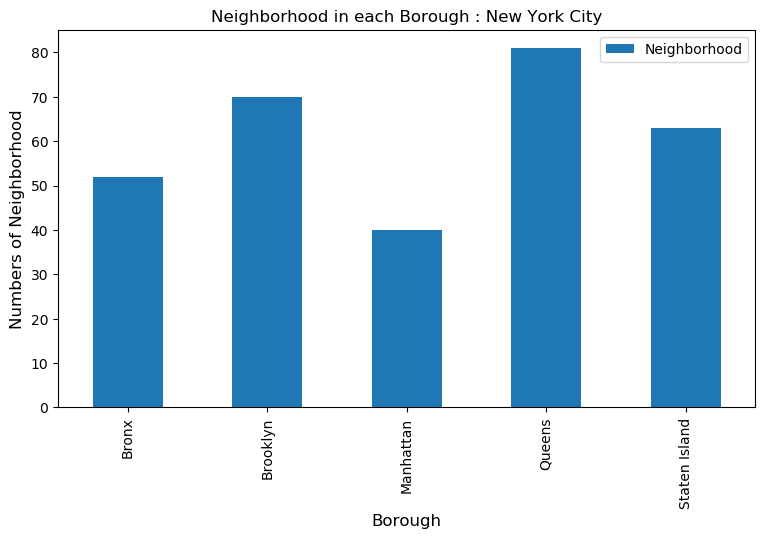

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Neighborhood in each Borough : New York City')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Numbers of Neighborhood', fontsize=12)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### We can easily understand with this bar plot that the Queens has higher number of neighborhoods

#### now let's collect data about French Restaurant

In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
frenchRest=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    french_resturants=venues[venues['Category']=='French Restaurant']   
    print('(',count,'/',len(new_york_data),')','French Resturants in '+Neighborhood+', '+Borough+':'+str(len(french_resturants)))
    for resturant_detail in french_resturants.values.tolist():
        id, name , category=resturant_detail
        frenchRest = frenchRest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) French Resturants in Wakefield, Bronx:0
( 2 / 306 ) French Resturants in Co-op City, Bronx:0
( 3 / 306 ) French Resturants in Eastchester, Bronx:0
( 4 / 306 ) French Resturants in Fieldston, Bronx:0
( 5 / 306 ) French Resturants in Riverdale, Bronx:0
( 6 / 306 ) French Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) French Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) French Resturants in Woodlawn, Bronx:0
( 9 / 306 ) French Resturants in Norwood, Bronx:0
( 10 / 306 ) French Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) French Resturants in Baychester, Bronx:0
( 12 / 306 ) French Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) French Resturants in City Island, Bronx:1
( 14 / 306 ) French Resturants in Bedford Park, Bronx:0
( 15 / 306 ) French Resturants in University Heights, Bronx:0
( 16 / 306 ) French Resturants in Morris Heights, Bronx:0
( 17 / 306 ) French Resturants in Fordham, Bronx:0
( 18 / 306 ) French Resturants in East Tremont, Bronx:0
( 19 / 306 ) Fre

( 143 / 306 ) French Resturants in Maspeth, Queens:0
( 144 / 306 ) French Resturants in Ridgewood, Queens:0
( 145 / 306 ) French Resturants in Glendale, Queens:0
( 146 / 306 ) French Resturants in Rego Park, Queens:0
( 147 / 306 ) French Resturants in Woodhaven, Queens:0
( 148 / 306 ) French Resturants in Ozone Park, Queens:0
( 149 / 306 ) French Resturants in South Ozone Park, Queens:0
( 150 / 306 ) French Resturants in College Point, Queens:0
( 151 / 306 ) French Resturants in Whitestone, Queens:0
( 152 / 306 ) French Resturants in Bayside, Queens:0
( 153 / 306 ) French Resturants in Auburndale, Queens:0
( 154 / 306 ) French Resturants in Little Neck, Queens:1
( 155 / 306 ) French Resturants in Douglaston, Queens:1
( 156 / 306 ) French Resturants in Glen Oaks, Queens:0
( 157 / 306 ) French Resturants in Bellerose, Queens:0
( 158 / 306 ) French Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) French Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) French Resturants in Briarw

( 280 / 306 ) French Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) French Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) French Resturants in Weeksville, Brooklyn:1
( 283 / 306 ) French Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) French Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) French Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) French Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) French Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) French Resturants in Egbertville, Staten Island:0
( 289 / 306 ) French Resturants in Roxbury, Queens:0
( 290 / 306 ) French Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) French Resturants in Middle Village, Queens:0
( 292 / 306 ) French Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) French Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) French Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) French Resturants in Malba, Queens:0
( 296 / 306 ) French Re

In [20]:
frenchRest.head()

,Borough,Neighborhood,ID,Name
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock
4,Brooklyn,Bedford Stuyvesant,5003007de4b06d50188aa593,Le Paris Dakar


In [21]:
frenchRest.shape

(61, 4)

### We can see that we have 61 French Restaurants in New York City

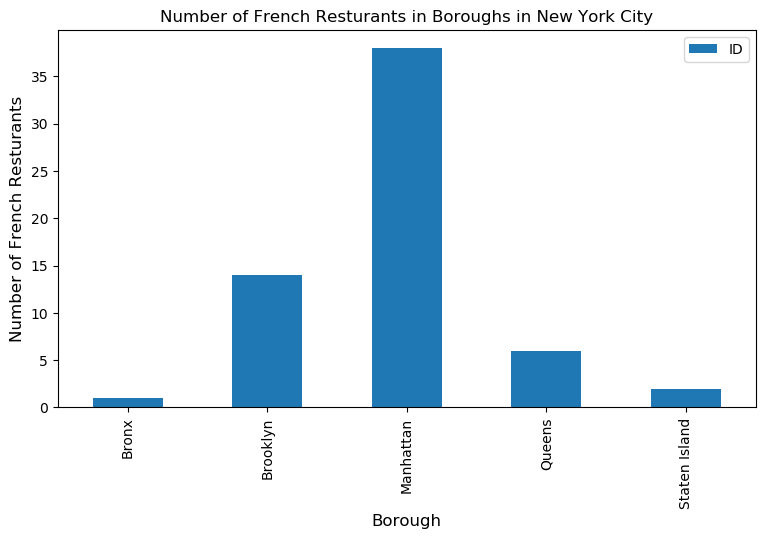

In [22]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of French Resturants in Boroughs in New York City')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Number of French Resturants', fontsize=12)
frenchRest.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

### we can see that Manhattan has highest number of French resturants

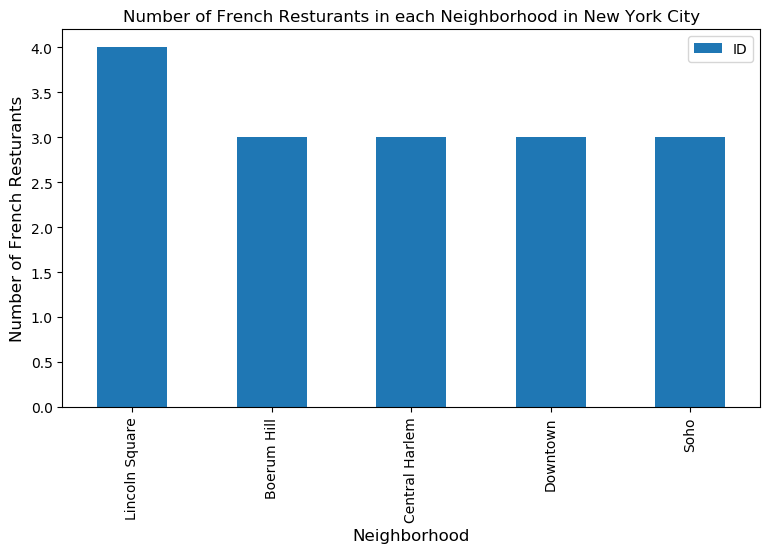

In [24]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of French Resturants in each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('Number of French Resturants', fontsize=12)
frenchRest.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [25]:
frenchRest[frenchRest['Neighborhood']=='Lincoln Square']

,Borough,Neighborhood,ID,Name
27,Manhattan,Lincoln Square,414ccc00f964a520d21c1fe3,Cafe Luxembourg
28,Manhattan,Lincoln Square,49e7897ff964a520b6641fe3,Nougatine at Jean Georges
29,Manhattan,Lincoln Square,3fd66200f964a520bee91ee3,Jean-Georges
30,Manhattan,Lincoln Square,41f19780f964a520101f1fe3,Per Se


### We can see that Lincoln Square in Manhattan has the highest number of French Resturants with a total of 4

Now lets get the ranking of each resturant for further analysis.

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
frenchRestanalysis=pd.DataFrame(columns=column_names)
count=1


for row in frenchRest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(frenchRest),')','processed')
    frenchRestanalysis = frenchRestanalysis.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4d7aa83ee540f04d66ba16dc  Bistro SK     13     7.6     7
( 1 / 61 ) processed
                         ID           Name  Likes  Rating  Tips
0  58fd34584382ab70ad90083e  Chez Ma Tante    212     8.7    58
( 2 / 61 ) processed
                         ID      Name  Likes  Rating  Tips
0  4bcf1883c564ef3ba33beff0  Le Gamin    158     8.0    73
( 3 / 61 ) processed
                         ID        Name  Likes  Rating  Tips
0  4e7d174cb6340a4da75a2cca  Le Paddock    135     8.8    56
( 4 / 61 ) processed
                         ID            Name  Likes  Rating  Tips
0  5003007de4b06d50188aa593  Le Paris Dakar    145     8.4    41
( 5 / 61 ) processed
                         ID      Name  Likes  Rating  Tips
0  4f7f8b86e4b088077df30175  Chez Moi    201     8.4    75
( 6 / 61 ) processed
                         ID      Name  Likes  Rating  Tips
0  4f7f8b86e4b088077df30175  Chez Moi    201     8.4    75
( 7 / 61 ) processed

KeyError: 'venue'

In [27]:
frenchRestanalysis.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.6,7
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,212,8.7,58
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,8.0,73
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.8,56
4,Brooklyn,Bedford Stuyvesant,5003007de4b06d50188aa593,Le Paris Dakar,145,8.4,41
5,Brooklyn,Brooklyn Heights,4f7f8b86e4b088077df30175,Chez Moi,201,8.4,75
6,Brooklyn,Cobble Hill,4f7f8b86e4b088077df30175,Chez Moi,201,8.4,75
7,Brooklyn,Gowanus,51e7e612498e001aa73959dd,Olivier Bistro,109,8.0,38
8,Brooklyn,Downtown,530931a5498e4079544a5f13,French Louie,569,8.5,115
9,Brooklyn,Downtown,4d20bc3af7a9a143bcab2f9f,The Little Sweet Café,65,8.1,32


In [28]:
frenchRestanalysis.shape

(50, 7)

### Now lets save all the data in CSV file

In [30]:
frenchRestanalysis.to_csv('french-Restaurant-analysis.csv', index = False)

In [31]:
df = pd.read_csv('french-Restaurant-analysis.csv')

In [32]:
df.shape

(50, 7)

In [33]:
df

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,City Island,4d7aa83ee540f04d66ba16dc,Bistro SK,13,7.6,7
1,Brooklyn,Greenpoint,58fd34584382ab70ad90083e,Chez Ma Tante,212,8.7,58
2,Brooklyn,Greenpoint,4bcf1883c564ef3ba33beff0,Le Gamin,158,8.0,73
3,Brooklyn,Windsor Terrace,4e7d174cb6340a4da75a2cca,Le Paddock,135,8.8,56
4,Brooklyn,Bedford Stuyvesant,5003007de4b06d50188aa593,Le Paris Dakar,145,8.4,41
5,Brooklyn,Brooklyn Heights,4f7f8b86e4b088077df30175,Chez Moi,201,8.4,75
6,Brooklyn,Cobble Hill,4f7f8b86e4b088077df30175,Chez Moi,201,8.4,75
7,Brooklyn,Gowanus,51e7e612498e001aa73959dd,Olivier Bistro,109,8.0,38
8,Brooklyn,Downtown,530931a5498e4079544a5f13,French Louie,569,8.5,115
9,Brooklyn,Downtown,4d20bc3af7a9a143bcab2f9f,The Little Sweet Café,65,8.1,32


In [34]:
df.info

<bound method DataFrame.info of           Borough        Neighborhood                        ID  \
0           Bronx         City Island  4d7aa83ee540f04d66ba16dc   
1        Brooklyn          Greenpoint  58fd34584382ab70ad90083e   
2        Brooklyn          Greenpoint  4bcf1883c564ef3ba33beff0   
3        Brooklyn     Windsor Terrace  4e7d174cb6340a4da75a2cca   
4        Brooklyn  Bedford Stuyvesant  5003007de4b06d50188aa593   
5        Brooklyn    Brooklyn Heights  4f7f8b86e4b088077df30175   
6        Brooklyn         Cobble Hill  4f7f8b86e4b088077df30175   
7        Brooklyn             Gowanus  51e7e612498e001aa73959dd   
8        Brooklyn            Downtown  530931a5498e4079544a5f13   
9        Brooklyn            Downtown  4d20bc3af7a9a143bcab2f9f   
10       Brooklyn            Downtown  3fd66200f964a52058f11ee3   
11       Brooklyn         Boerum Hill  530931a5498e4079544a5f13   
12       Brooklyn         Boerum Hill  4d20bc3af7a9a143bcab2f9f   
13       Brooklyn         Boer

In [37]:
frenchRestanalysis['Likes']=frenchRestanalysis['Likes'].astype('float64')
frenchRestanalysis['Tips']=frenchRestanalysis['Tips'].astype('float64')

### Resturant with maximum Likes

In [39]:
frenchRestanalysis.iloc[frenchRestanalysis['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1851
Rating                               9.2
Tips                                 519
Name: 42, dtype: object

### Resturant with maximum Ratings

In [40]:
frenchRestanalysis.iloc[frenchRestanalysis['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                 East Harlem
ID              553c1b00498e7eb81316bf1b
Name                       Mountain Bird
Likes                                 80
Rating                               9.3
Tips                                  18
Name: 20, dtype: object

### Resturant with maximum Tips

In [41]:
frenchRestanalysis.iloc[frenchRestanalysis['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              4d0bf7e3f29c236ac675bfe7
Name                             Buvette
Likes                               1851
Rating                               9.2
Tips                                 519
Name: 42, dtype: object

##  Now lets see neighborhood with maximum average rating of resturants.

In [56]:
dfneighborhood=frenchRestanalysis.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
dfneighborhood.columns=['Neighborhood','Average Rating']

In [57]:
dfneighborhood.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Harlem,9.30
25,Soho,8.90
13,Greenwich Village,8.90
5,Chinatown,8.90
16,Little Italy,8.90
18,Lower East Side,8.85
30,Yorkville,8.80
29,Windsor Terrace,8.80
28,West Village,8.75
23,Rockaway Park,8.70


## Above are the top neighborhoods with top average rating of French resturants.¶

Similarly we will find the average rating of French Resturants for each Borough.

In [44]:
dfBorough=frenchRestanalysis.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
dfBorough.columns=['Borough','Average Rating']

In [45]:
dfBorough.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.683871
1,Brooklyn,8.330769
3,Queens,8.025000
0,Bronx,7.600000
4,Staten Island,7.200000


## it's time for visualization

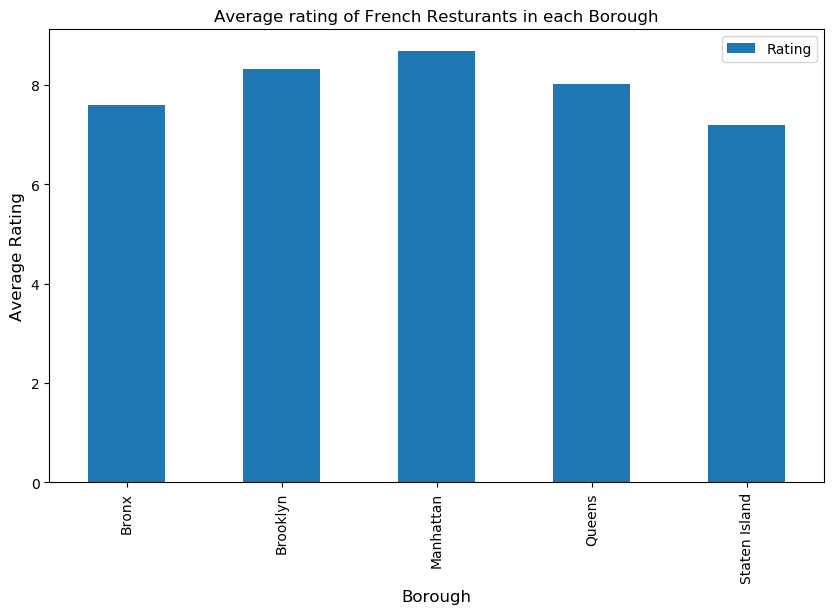

In [47]:
plt.figure(figsize=(10,6), dpi = 100)
plt.title('Average rating of French Resturants in each Borough')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Average Rating', fontsize=12)
frenchRestanalysis.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.5 to visualize on map.

In [60]:
dfneighborhood=dfneighborhood[dfneighborhood['Average Rating']>=8.5]

In [61]:
dfneighborhood

,Neighborhood,Average Rating
0,Battery Park City,8.60
5,Chinatown,8.90
10,East Harlem,9.30
13,Greenwich Village,8.90
14,Lenox Hill,8.60
15,Lincoln Square,8.70
16,Little Italy,8.90
18,Lower East Side,8.85
19,Manhattanville,8.50
23,Rockaway Park,8.70


We will join this dataset to original new york data to get lonitude and latitude.

In [62]:
dfneighborhood=pd.merge(dfneighborhood,new_york_data, on='Neighborhood')

In [63]:
dfneighborhood=dfneighborhood[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [64]:
dfneighborhood

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Battery Park City,40.711932,-74.016869,8.60
1,Manhattan,Chinatown,40.715618,-73.994279,8.90
2,Manhattan,East Harlem,40.792249,-73.944182,9.30
3,Manhattan,Greenwich Village,40.726933,-73.999914,8.90
4,Manhattan,Lenox Hill,40.768113,-73.958860,8.60
5,Manhattan,Lincoln Square,40.773529,-73.985338,8.70
6,Manhattan,Little Italy,40.719324,-73.997305,8.90
7,Manhattan,Lower East Side,40.717807,-73.980890,8.85
8,Manhattan,Manhattanville,40.816934,-73.957385,8.50
9,Queens,Rockaway Park,40.580343,-73.841534,8.70


### Let show this data on a map

In [65]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [67]:
incidents = folium.map.FeatureGroup()
for lat, lng, in dfneighborhood[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling.

In [68]:
dfneighborhood['Label']=dfneighborhood['Neighborhood']+', '+dfneighborhood['Borough']+'('+dfneighborhood['Average Rating'].map(str)+')'

In [69]:
for lat, lng, label in dfneighborhood[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(incidents)

<h1 style="text-align:center"><strong>Conclusion</strong></h1>

# 1. Lincoln Square, Boerum hill, Central Harlem, downtown and Soho are the best locations for french Restaurant

# 2. Manhattan have potential french Market

# 3. The bronx rank last about french Restaurant

# 4. Manhattan is the best place to stay if you like French Restaurant